<center><h1>Shrey_Shah_HW8</h1></center>

Name: Shrey Shah<br>Github Username: shreyshah97<br>USC ID: 5061063668

#### Note: I am using my one late day for this homework.

# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy.special import softmax
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

# 1. Supervised, Semi-Supervised, and Unsupervised Learning

## (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
cancer_data_filename = "../data/wdbc.data.csv"
banknote_cancer_data_filename = "../data/data_banknote_authentication.txt"
summary = {}

In [3]:
df_train = pd.read_csv(cancer_data_filename, header = None)
df_train.replace({'M': 1, 'B': 0}, inplace = True)
df_train.columns = ['id', 'label'] + [f'col{i}' for i in range(1, 31)]
df_train.head()

,id,label,col1,col2,col3,col4,col5,col6,col7,col8,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## (b) Monte-Carlo Simulation

In [4]:
def split_custom(df_train, random_state, test_size = 0.2):
    
    np.random.seed(random_state)
    label_0_index, = np.where(df_train['label'] == 0)    
    label_0_test_index = np.random.choice(label_0_index, round(len(label_0_index) * test_size), replace = False)
    
    label_1_index, = np.where(df_train['label'] == 1)
    label_1_test_index = np.random.choice(label_1_index, round(len(label_1_index) * test_size), replace = False)
    
    test_index = np.concatenate([label_0_test_index, label_1_test_index])
    train_index = np.array([i for i in range(df_train.shape[0]) if i not in test_index])
    
    x_train = df_train.iloc[train_index, 2:].copy()
    y_train = df_train.iloc[train_index, 1].copy()
    x_test = df_train.iloc[test_index, 2:].copy()
    y_test = df_train.iloc[test_index, 1].copy()
    return x_train, x_test, y_train, y_test

def normalize_data(x_train, x_test):    
    return Normalizer().fit_transform(x_train), Normalizer().fit_transform(x_test)

In [5]:
def plot_auc_roc_curve(y_true, prob, title):
    fpr, tpr, _ = roc_curve(y_true, prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    _, axes = plt.subplots(figsize = (6, 4))
    axes.plot([0, 1], [0, 1], "--")
    axes.plot(fpr, tpr, label = f"ROC Curve Area: {round(roc_auc, 4)}")
    axes.set_title(f"ROC curve for {title}")    
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()
    
def print_results(y_true, y_pred, prob, title):
    score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"\nAnalysis Summary for {title}\n")
    print(f'Accuracy Score is: {round(score, 4)}')
    print(f'Confusion Matrix is: \n{conf_matrix}')
    plot_auc_roc_curve(y_true, prob, title) 

def get_model_summary(model, x_data, y_data):
    probability = model.decision_function(x_data)
    predictions = model.predict(x_data)
    results = classification_report(y_data, predictions, output_dict = True)
    fpr, tpr, _ = roc_curve(y_data, probability, pos_label = 1)
    return {
        'local_results': {
            'acc' : results['accuracy'],
            'precision' : results['weighted avg']['precision'],
            'recall' : results['weighted avg']['recall'],
            'f1-score' : results['weighted avg']['f1-score'],
            'auc' : round(auc(fpr, tpr), 4)
        },
        'predictions': predictions,
        'probability': probability,
    }

def summarize_results(df_train, df_test):
    df_train_mean = df_train.apply(lambda x: x.mean(), axis = 0)
    df_test_mean = df_test.apply(lambda x: x.mean(), axis = 0)
    data = [df_train_mean, df_test_mean]
    summary = pd.concat(data, axis = 1).T
    summary.index = ['training', 'test']
    return summary

In [6]:
def svm_semi_supervised(x_train, y_train, args):
    labeled_index = []
    unlabeled_index = []
    
    for c in [0, 1]:
        c_label_index, = np.where(y_train == c)
        labeled_index.extend(np.random.choice(c_label_index, round(len(c_label_index) * 0.5), replace = False))
    
    for i in range(len(x_train)):
        if i not in labeled_index:
            unlabeled_index.append(i)

    x_labeled = x_train.iloc[labeled_index].to_numpy().tolist()
    y_labeled = y_train.iloc[labeled_index].to_numpy().tolist()
    x_unlabeled = x_train.iloc[unlabeled_index].to_numpy().tolist()
    y_unlabeled = y_train.iloc[unlabeled_index].to_numpy().tolist()
    
    model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **args)
    model.fit(x_labeled, y_labeled)
    
    while len(x_unlabeled) > 0:
        scores = model.decision_function(x_unlabeled)
        sorted_index = sorted([i for i in range(len(x_unlabeled))], key = lambda x : abs(scores[x]))
        x_unlabeled = [x_unlabeled[i] for i in sorted_index]
        y_unlabeled = [y_unlabeled[i] for i in sorted_index]
        x_labeled.append(x_unlabeled.pop())
        y_labeled.append(y_unlabeled.pop())
        model.best_estimator_.fit(x_labeled, y_labeled) 
    return model

def svm_mc(df_train, iters, input_model):
    
    end = 10 if input_model == 'semi-supervised-svm' else 20
    kwargs = {
        'param_grid' : {'C' : np.logspace(-2, 7, end)}, 
        'scoring' : 'f1_weighted',
        'n_jobs' : -1
    }
    
    stats = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    df_train_stats = pd.DataFrame(columns = stats)
    df_test_stats = pd.DataFrame(columns = stats)
    print('Iteration\tTrain Accuracy\tTest Accuracy\tBest Params')
    
    for i in range(iters):
        x_train, x_test, y_train, y_test = split_custom(df_train, i)
        x_train, x_test = normalize_data(x_train, x_test)
        x_train, x_test = pd.DataFrame(x_train), pd.DataFrame(x_test)
        
        if (input_model == 'supervised-svm'):
            kwargs['cv'] = StratifiedKFold(5, random_state = i, shuffle = True)
            model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
            model.fit(x_train, y_train)
        elif (input_model == 'semi-supervised-svm'):
            model = svm_semi_supervised(x_train, y_train, kwargs)
        else:
            model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
            model.fit(x_train, y_train)
            
        stats_train = get_model_summary(model, x_train, y_train)
        stats_test = get_model_summary(model, x_test, y_test)
        df_train_stats = df_train_stats.append(stats_train['local_results'], ignore_index = True)
        df_test_stats = df_test_stats.append(stats_test['local_results'], ignore_index = True)
        acc_train, acc_test = stats_train['local_results']['acc'], stats_test['local_results']['acc']
        print(f'{i + 1}\t\t{round(acc_train, 4)}\t\t{round(acc_test, 4)}\t\t{model.best_params_}')
        
    print_results(y_train, stats_train['predictions'], stats_train['probability'], "Training")
    print_results(y_test, stats_test['predictions'], stats_test['probability'], "Testing")
    summary = summarize_results(df_train_stats, df_test_stats)
    return summary

### (i) Supervised Learning

In [7]:
x_train, x_test, y_train, y_test = split_custom(df_train, 0)

In [8]:
x_train.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
0,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
3,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.1700,0.1578,0.08089,0.2087,0.07613,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.1090,0.1127,0.07400,0.1794,0.05742,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368


In [9]:
x_test.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
49,13.490,22.30,86.91,561.0,0.08752,0.07698,0.04751,0.033840,0.1809,0.05718,...,15.15,31.82,99.00,698.8,0.1162,0.17110,0.228200,0.128200,0.2871,0.06917
285,12.580,18.40,79.83,489.0,0.08393,0.04216,0.00186,0.002924,0.1697,0.05855,...,13.50,23.08,85.56,564.1,0.1038,0.06624,0.005579,0.008772,0.2505,0.06431
495,14.870,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.049510,0.1487,0.05748,...,16.01,28.48,103.90,783.6,0.1216,0.13880,0.170000,0.101700,0.2369,0.06599
391,8.734,16.84,55.27,234.3,0.10390,0.07428,0.00000,0.000000,0.1985,0.07098,...,10.17,22.80,64.01,317.0,0.1460,0.13100,0.000000,0.000000,0.2445,0.08865
187,11.710,17.19,74.68,420.3,0.09774,0.06141,0.03809,0.032390,0.1516,0.06095,...,13.01,21.39,84.42,521.5,0.1323,0.10400,0.152100,0.109900,0.2572,0.07097


In [10]:
display(y_train.value_counts())
display(y_test.value_counts())

0    286
1    170
Name: label, dtype: int64

0    71
1    42
Name: label, dtype: int64

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9956		0.9646		{'C': 127427.49857031321}
2		0.9759		0.9558		{'C': 1623.776739188721}
3		0.9759		0.9204		{'C': 1623.776739188721}
4		0.989		0.9646		{'C': 14384.498882876629}
5		0.9978		0.9558		{'C': 42813.32398719387}
6		0.9868		0.9469		{'C': 14384.498882876629}
7		0.9781		0.9646		{'C': 14384.498882876629}
8		0.9846		0.9558		{'C': 42813.32398719387}
9		0.9912		0.9735		{'C': 10000000.0}
10		0.9737		1.0		{'C': 4832.930238571752}
11		0.989		0.9381		{'C': 1128837.8916846884}
12		0.9825		0.9912		{'C': 4832.930238571752}
13		0.9803		0.9823		{'C': 4832.930238571752}
14		0.9825		0.9646		{'C': 4832.930238571752}
15		0.9825		0.9558		{'C': 14384.498882876629}
16		0.9912		0.9469		{'C': 14384.498882876629}
17		0.9912		0.9292		{'C': 14384.498882876629}
18		0.9825		0.9823		{'C': 42813.32398719387}
19		0.9737		0.9735		{'C': 14384.498882876629}
20		0.9781		0.9823		{'C': 42813.32398719387}
21		0.9912		0.9646		{'C': 4832.930238571752}
22		0.989		0.973

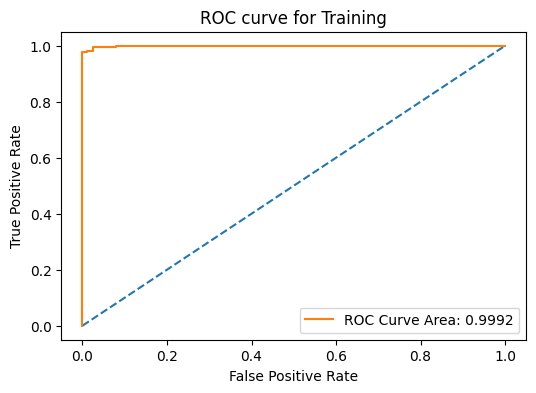


Analysis Summary for Testing

Accuracy Score is: 0.9469
Confusion Matrix is: 
[[69  2]
 [ 4 38]]


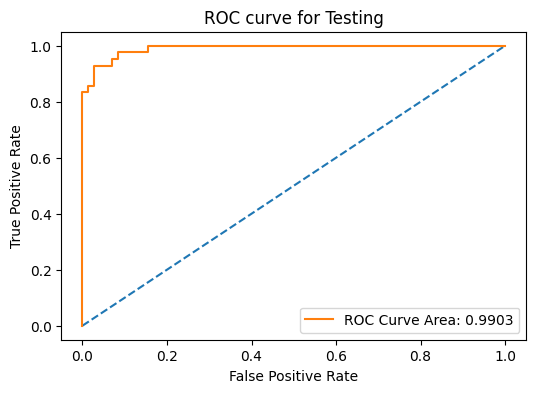

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.983699,0.983734,0.983699,0.983676,0.998637
test,0.960767,0.961201,0.960767,0.960663,0.988620


In [11]:
summary['supervised-svm'] = svm_mc(df_train, 30, 'supervised-svm')
df = pd.DataFrame(summary['supervised-svm'])
print("Summarizing Results.....")
display(df)

### (ii) Semi-Supervised Learning/ Self-training

#### Performing (A) & (B) together

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9956		0.9735		{'C': 10000000.0}
2		0.9781		0.9735		{'C': 10000.0}
3		0.989		0.9469		{'C': 10000.0}
4		0.9956		0.9646		{'C': 100000.0}
5		0.989		0.9646		{'C': 10000.0}
6		0.9846		0.9469		{'C': 10000.0}
7		0.9781		0.9646		{'C': 100000.0}
8		0.989		0.9558		{'C': 1000000.0}
9		0.9868		0.9646		{'C': 10000.0}
10		0.9715		1.0		{'C': 10000.0}
11		0.9868		0.9469		{'C': 100000.0}
12		0.989		0.9823		{'C': 100000.0}
13		0.9803		0.9823		{'C': 100000.0}
14		0.989		0.9646		{'C': 10000.0}
15		0.9671		0.9381		{'C': 1000.0}
16		0.9912		0.9381		{'C': 10000.0}
17		0.989		0.9381		{'C': 10000.0}
18		0.9605		0.9735		{'C': 1000.0}
19		0.9825		0.9558		{'C': 100000.0}
20		0.9825		0.9735		{'C': 100000.0}
21		0.9868		0.9646		{'C': 10000.0}
22		0.989		0.9646		{'C': 100000.0}
23		0.9846		0.9558		{'C': 10000000.0}
24		0.9825		0.9381		{'C': 10000.0}
25		0.9715		0.9823		{'C': 10000.0}
26		0.9781		0.9381		{'C': 1000.0}
27		0.9825		0.9558		{'C': 10000.0}
28		0.9715

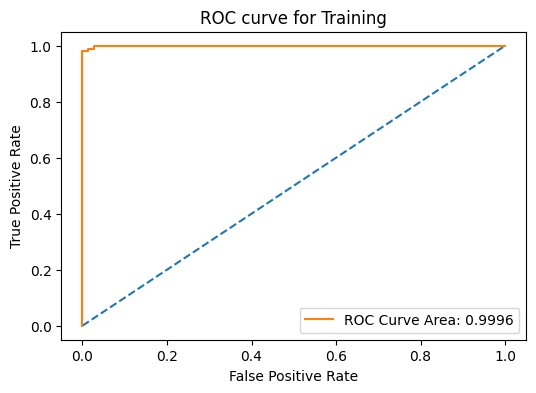


Analysis Summary for Testing

Accuracy Score is: 0.9381
Confusion Matrix is: 
[[69  2]
 [ 5 37]]


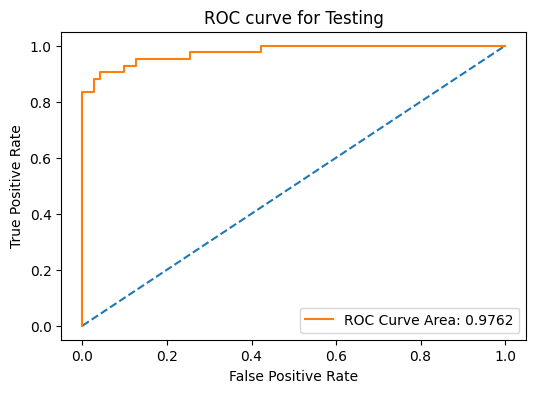

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.983333,0.983353,0.983333,0.98331,0.998627
test,0.959882,0.960348,0.959882,0.95974,0.988337


In [12]:
summary['semi-supervised-svm'] = svm_mc(df_train, 30, 'semi-supervised-svm')
df = pd.DataFrame(summary['semi-supervised-svm'])
print("Summarizing Results.....")
display(df)

### (iii) Unsupervised Learning

#### (A) How do you make sure that the algorithm was not trapped in a local minimum?
**Ans : We should set the number of iterations to avoid being trapped in a local minimum.**

#### Performing (A), (B) and (C) together

In [13]:
def results_summary(true_labels, probability, report):
    fpr, tpr, _ = roc_curve(true_labels, probability, pos_label = 1)
    roc_auc = round(auc(fpr, tpr), 4)
    return {
        'acc' : report['accuracy'],
        'precision' : report['weighted avg']['precision'],
        'recall' : report['weighted avg']['recall'],
        'f1-score' : report['weighted avg']['f1-score'],
        'auc' : roc_auc
    }

def calculate_distance(centers, X, label_cluster):
    dist = np.ndarray((X.shape[0],))
    proba = np.ndarray((X.shape[0], 2))
    for i, x in enumerate(X):
        center = centers[label_cluster[i]]
        dist[i] = np.linalg.norm(x - center)
        proba[i, 0] = np.linalg.norm(x - centers[0])
        proba[i, 1] = np.linalg.norm(x - centers[1])
    
    proba = softmax(proba, axis=1).astype(np.float64)
    return dist, proba

def majority_voting(label_cluster, distance, Y):
    label2cluster = np.ndarray((2,), dtype='int')
    major_label = label_cluster.copy()
    for cluster in [0, 1]:
        sample_index, = np.where(label_cluster == cluster)
        top30 = sorted(sample_index.tolist(), key=lambda i : distance[i])[:30]
        majority = Y.iloc[top30].value_counts().index[0]
        major_label[sample_index] = majority
        label2cluster[majority] = cluster
    return label2cluster, major_label

def unsupervised_mc(data, n, input_model):
    
    stats = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    df_train = pd.DataFrame(columns = stats)
    df_test = pd.DataFrame(columns = stats)
    print('Iteration\tTrain Accuracy\tTest Accuracy')
    
    for i in range(n):
        x_train, x_test, y_train, y_test = split_custom(data, i)
        x_train, x_test = normalize_data(x_train, x_test)
        
        if input_model == 'unsupervised-kmeans':
            model = KMeans(n_clusters = 2, n_init = 15, random_state = i).fit(x_train)
            predicted_label = model.predict(x_train)
            cluster_centroid = model.cluster_centers_
        else:  
            label_cluster = SpectralClustering(n_clusters = 2, assign_labels = 'kmeans', affinity = 'rbf', 
                                               eigen_tol = 1e-2, eigen_solver = 'arpack', random_state = 0
                                              ).fit_predict(x_train)
            cluster_centroid = []
            cluster_centroid.append(np.mean(x_train[label_cluster == 0], axis = 0).tolist())
            cluster_centroid.append(np.mean(x_train[label_cluster == 1], axis = 0).tolist())
            model = KNeighborsClassifier(n_neighbors = 1).fit(x_train, label_cluster)
            predicted_label = model.predict(x_train)
        
        distance, probability = calculate_distance(cluster_centroid, x_train, predicted_label)
        label2cluster, predictions = majority_voting(predicted_label, distance, y_train)
        probability = probability[:, label2cluster[0]]
        model_results = classification_report(y_train, predictions, output_dict = True)
        local_result = results_summary(y_train, probability, model_results)
        df_train = df_train.append(local_result, ignore_index = True)
        
        predicted_label_test = model.predict(x_test)
        distance_test, probability_test = calculate_distance(cluster_centroid, x_test, predicted_label_test)
        label2cluster, predictions_test = majority_voting(predicted_label_test, distance_test, y_test)
        probability_test = probability_test[:, label2cluster[0]]
        model_results_test = classification_report(y_test, predictions_test, output_dict = True)
        local_result_test = results_summary(y_test, probability_test, model_results_test)
        df_test = df_test.append(local_result_test, ignore_index = True)
        
        acc_train = model_results['accuracy']
        acc_test = model_results_test['accuracy']
        print(f'{i + 1}\t\t{round(acc_train, 4)}\t\t{round(acc_test, 4)}')
    
    
    print_results(y_train, predictions, probability, 'Training')
    print_results(y_test, predictions_test, probability_test, 'Test')
    summary = summarize_results(df_train, df_test)
    return summary

Iteration	Train Accuracy	Test Accuracy
1		0.8882		0.8761
2		0.8706		0.9558
3		0.8969		0.8496
4		0.886		0.9115
5		0.8991		0.8761
6		0.886		0.8673
7		0.8794		0.8938
8		0.886		0.8673
9		0.8882		0.8584
10		0.8794		0.8938
11		0.8925		0.8761
12		0.8794		0.9115
13		0.8816		0.9027
14		0.8882		0.8938
15		0.8969		0.8496
16		0.8772		0.9027
17		0.9013		0.8319
18		0.8838		0.9115
19		0.886		0.885
20		0.8991		0.8584
21		0.8838		0.9115
22		0.8794		0.8938
23		0.8882		0.885
24		0.8904		0.8496
25		0.8947		0.8761
26		0.8991		0.8407
27		0.8838		0.9027
28		0.886		0.8938
29		0.8904		0.9027
30		0.8925		0.8407

Analysis Summary for Training

Accuracy Score is: 0.8925
Confusion Matrix is: 
[[282   4]
 [ 45 125]]


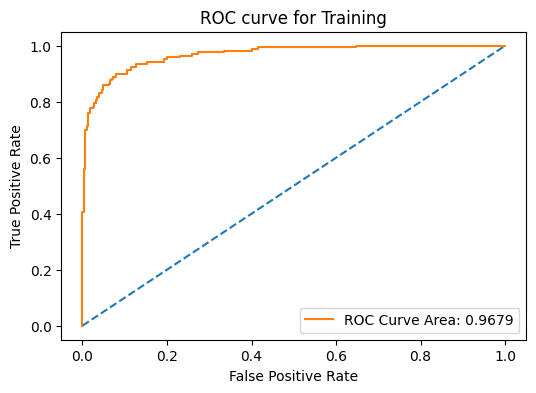


Analysis Summary for Test

Accuracy Score is: 0.8407
Confusion Matrix is: 
[[70  1]
 [17 25]]


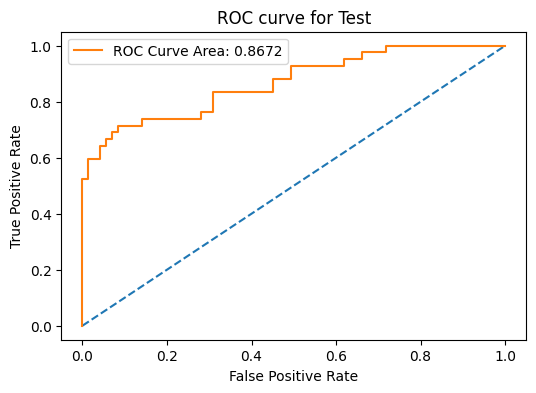

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.887792,0.896542,0.887792,0.883912,0.950717
test,0.882301,0.894138,0.882301,0.877143,0.945860


In [14]:
summary['unsupervised-kmeans'] = unsupervised_mc(df_train, 30, 'unsupervised-kmeans')
df = pd.DataFrame(summary['unsupervised-kmeans'])
print("Summarizing Results.....")
display(df)

### (iv) Spectral Clustering

Iteration	Train Accuracy	Test Accuracy
1		0.886		0.885
2		0.8684		0.9204
3		0.8925		0.8407
4		0.8794		0.8761
5		0.8838		0.8761
6		0.8838		0.8761
7		0.8728		0.8938
8		0.8838		0.8496
9		0.886		0.8496
10		0.8772		0.8761
11		0.8904		0.8496
12		0.8794		0.8938
13		0.8794		0.8938
14		0.8794		0.885
15		0.8925		0.8053
16		0.8728		0.885
17		0.8947		0.823
18		0.8816		0.9292
19		0.8838		0.8761
20		0.8925		0.8584
21		0.875		0.9115
22		0.8794		0.885
23		0.8838		0.8761
24		0.8838		0.8496
25		0.8882		0.8496
26		0.8925		0.8407
27		0.8772		0.8938
28		0.8772		0.885
29		0.8772		0.8938
30		0.8925		0.823

Analysis Summary for Training

Accuracy Score is: 0.8925
Confusion Matrix is: 
[[282   4]
 [ 45 125]]


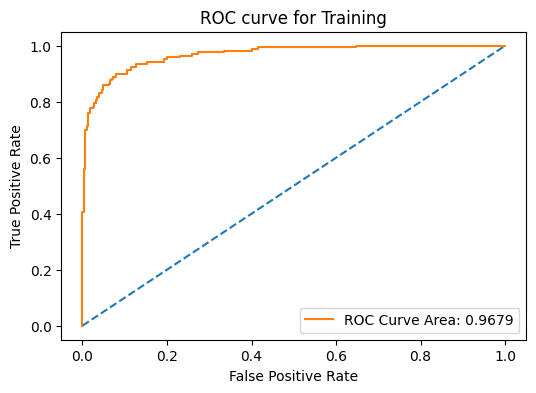


Analysis Summary for Test

Accuracy Score is: 0.823
Confusion Matrix is: 
[[69  2]
 [18 24]]


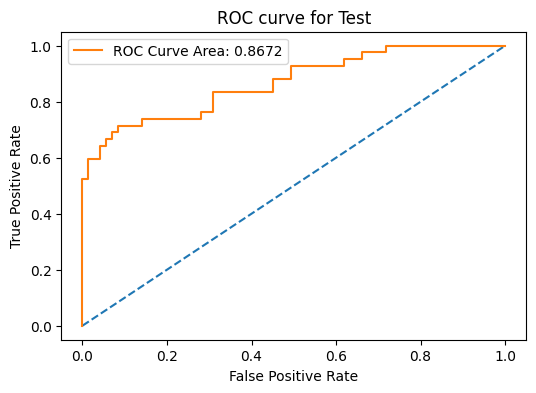

Summarizing Results.....


,acc,precision,recall,f1-score,auc
training,0.882895,0.893003,0.882895,0.878464,0.950147
test,0.871681,0.885106,0.871681,0.865377,0.945257


In [15]:
summary['unsupervised-spectral'] = unsupervised_mc(df_train, 30, 'unsupervised-spectral')
df = pd.DataFrame(summary['unsupervised-spectral'])
print("Summarizing Results.....")
display(df)

### (iv) Compare

In [16]:
for key in summary.keys():
    print('-'*80 + '\n' + key + '\n' + '-'*80 + '\n', summary[key])

--------------------------------------------------------------------------------
supervised-svm
--------------------------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.983699   0.983734  0.983699  0.983676  0.998637
test      0.960767   0.961201  0.960767  0.960663  0.988620
--------------------------------------------------------------------------------
semi-supervised-svm
--------------------------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.983333   0.983353  0.983333   0.98331  0.998627
test      0.959882   0.960348  0.959882   0.95974  0.988337
--------------------------------------------------------------------------------
unsupervised-kmeans
--------------------------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.887792   0.896542  0.887

### Observation:

Based on the summary results, it can be inferred that the supervised method performs better than the semi-supervised method, and the semi-supervised method performs better than the unsupervised method. However, the difference in performance between the semi-supervised and unsupervised methods is more prominent than the difference between the supervised and semi-supervised methods. This observation is expected since the supervised method has access to more label information to guide its predictions, whereas the semi-supervised method has less. In contrast, the unsupervised method relies on feature similarity to make predictions, which leads to poorer performance compared to the supervised and semi-supervised methods.

# 2. Active Learning Using Support Vector Machines

## (a) Download the banknote authentication Data Set

In [17]:
df_train = pd.read_csv(banknote_cancer_data_filename, header = None)
df_train.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df_train.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [18]:
def random_split(df_train):    

    test_index = np.random.choice(df_train.shape[0], 472, replace = False)
    temp_list = []
    for i in range(df_train.shape[0]):
        if i not in test_index:
            temp_list.append(i); 
    train_index = np.array(temp_list)
    x_train = df_train.iloc[train_index]
    x_test = df_train.iloc[test_index]
    return x_train, x_test

x_train, x_test = random_split(df_train)

In [19]:
x_train.head()

,variance,skewness,curtosis,entropy,class
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0
5,4.36840,9.6718,-3.9606,-3.16250,0
7,2.09220,-6.8100,8.4636,-0.60216,0


In [20]:
x_test.head()

,variance,skewness,curtosis,entropy,class
989,-6.7526,8.81720,-0.061983,-3.72500,1
765,-3.8483,-12.80470,15.682400,-1.28100,1
1036,-2.3898,-0.78427,3.014100,0.76205,1
268,0.9297,-3.79710,4.642900,-0.29570,0
1106,-0.1269,-1.15050,-0.951380,0.57843,1


## (b) Repeat each of the following two procedures 50 times

In [21]:
def active_learning(x_train, y_train, x_test, y_test, kwargs):
    all_index = np.arange(x_train.shape[0])
    new_index, accuracy = [], []
    np.random.shuffle(all_index)
    pool, all_index = all_index[:10], all_index[10:]
    new_index.extend(pool)
    
    while len(new_index) <= 900:
        x_train_new, y_train_new = x_train.iloc[new_index], y_train.iloc[new_index]
        model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
        model.fit(x_train_new, y_train_new)
        predictions = model.predict(x_test)
        result = classification_report(y_test, predictions, output_dict = True)
        accuracy.append(result['accuracy'])
        
        if len(all_index) == 0:
            break
        
        dist = model.decision_function(x_train.iloc[all_index])
        sortedarg = np.arange(len(all_index))
        sorted(sortedarg, key=lambda i : abs(dist[i]))
        all_index = all_index[sortedarg]
        pool, all_index = all_index[:10], all_index[10:]
        new_index.extend(pool)
        
    return accuracy

def passive_learning(x_train, y_train, x_test, y_test, kwargs):
    all_index = np.arange(x_train.shape[0])
    new_index, accuracy = [], []
    while len(all_index) > 0:
        np.random.shuffle(all_index)
        pool, all_index = all_index[:10], all_index[10:]
        new_index.extend(pool)
        
        x_train_new, y_train_new = x_train.iloc[new_index], y_train.iloc[new_index]
        model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
        model.fit(x_train_new, y_train_new)
        predictions = model.predict(x_test)
        result = classification_report(y_test, predictions, output_dict = True)
        accuracy.append(result['accuracy'])
    return accuracy

def mc_active_passive(df_train, iters, _type):

    kwargs = {
        'param_grid' : {'C' : np.logspace(-2, 7, 20)}, 
        'scoring' : 'f1_weighted',
        'n_jobs' : -1
    }
    
    learning_curve = []   
    print('Iteration\tTrain Accuracy\tTest Accuracy')
    for i in range(iters):
        df_train_new, df_test_new = random_split(df_train)
        x_train, y_train = df_train_new.iloc[:, :-1], df_train_new.iloc[:, -1]
        x_test, y_test = df_test_new.iloc[:, :-1], df_test_new.iloc[:, -1]
        x_train, x_test = normalize_data(x_train, x_test)
        x_train, x_test = pd.DataFrame(x_train), pd.DataFrame(x_test)
        kwargs['cv'] = StratifiedKFold(5, random_state = i, shuffle = True)
         
        if _type == 'passive':  
            accuracy = passive_learning(x_train, y_train, x_test, y_test, kwargs)
        else:
            accuracy = active_learning(x_train, y_train, x_test, y_test, kwargs)
        learning_curve.append(accuracy)
        print(f'{i + 1}\t\t{round(accuracy[0], 4)}\t\t{round(accuracy[-1], 4)}')

    learning_curve = np.mean(np.array(learning_curve), axis = 0)
    return learning_curve

def plot_learning_curve(active, passive):
    
    _, axes = plt.subplots(figsize=(6, 4))
    x = 10 * np.arange(1, 91)
    axes.plot(x, 1 - passive, label = 'Passive')
    axes.plot(x, 1 - active, label = 'Active')
    axes.set_title("Learning Curve")
    axes.set_xlabel("Training Size")
    axes.set_ylabel("Test Error")
    axes.legend()
    plt.show()

### (i) Passive

In [22]:
passive_learning_curve = mc_active_passive(df_train, 50, 'passive')

Iteration	Train Accuracy	Test Accuracy
1		0.8496		0.9979
2		0.9131		0.9915
3		0.8263		0.9936
4		0.9258		0.9958
5		0.8326		0.9915
6		0.7733		0.9958
7		0.8517		0.9936
8		0.6419		0.9979
9		0.9195		0.9936
10		0.9746		0.9915
11		0.8559		0.9936
12		0.8814		0.9936
13		0.9725		0.9936
14		0.8771		0.9915
15		0.6462		0.9958
16		0.5403		0.9936
17		0.9576		0.9915
18		0.8898		0.9936
19		0.7352		0.9915
20		0.7394		0.9936
21		0.8941		0.9936
22		0.8644		0.9894
23		0.7712		0.9831
24		0.8263		0.9894
25		0.9343		0.9852
26		0.8072		0.9958
27		0.9513		0.9936
28		0.9407		0.9915
29		0.928		0.9979
30		0.8517		0.9915
31		0.9492		0.9936
32		0.947		0.9979
33		0.7987		0.9958
34		0.5742		0.9852
35		0.8941		0.9958
36		0.6208		0.9958
37		0.9492		0.9958
38		0.7436		0.9894
39		0.9131		0.9936
40		0.8686		0.9958
41		0.8623		0.9936
42		0.9831		0.9936
43		0.8178		0.9915
44		0.928		0.9936
45		0.6864		0.9894
46		0.8919		0.9958
47		0.822		0.9915
48		0.8644		0.9894
49		0.8856		0.9915
50		0.8835		0.9936


### (ii) Active

In [23]:
active_learning_curve = mc_active_passive(df_train, 50, 'active')

Iteration	Train Accuracy	Test Accuracy
1		0.9597		0.9958
2		0.9852		0.9936
3		0.8432		0.9979
4		0.8581		0.9936
5		0.8686		0.9958
6		0.9788		0.9958
7		0.5784		0.9958
8		0.9894		0.9894
9		0.6504		0.9958
10		0.8729		0.9936
11		0.8771		0.9915
12		0.8072		0.9915
13		0.8814		0.9915
14		0.8729		0.9873
15		0.9597		0.9915
16		0.7987		0.9894
17		0.7352		0.9979
18		0.8602		0.9873
19		0.661		0.9936
20		0.8475		0.9958
21		0.9555		0.9915
22		0.8432		0.9936
23		0.8051		0.9852
24		0.8496		0.9958
25		0.8136		0.9936
26		0.928		0.9936
27		0.7669		0.9936
28		0.9682		0.9936
29		0.839		0.9936
30		0.8326		0.9936
31		0.964		0.9936
32		0.9089		0.9936
33		0.9089		0.9958
34		0.8686		0.9915
35		0.8644		0.9915
36		0.8475		0.9915
37		0.8453		0.9936
38		0.8453		0.9958
39		0.8792		0.9894
40		0.8686		0.9936
41		0.8284		0.9979
42		0.8453		0.9936
43		0.8835		0.9894
44		0.8962		0.9894
45		0.9089		0.9894
46		0.8517		0.9979
47		0.8538		0.9979
48		0.9725		0.9936
49		0.7775		0.9936
50		0.5699		0.9979


## (c) Average the 50 test errors

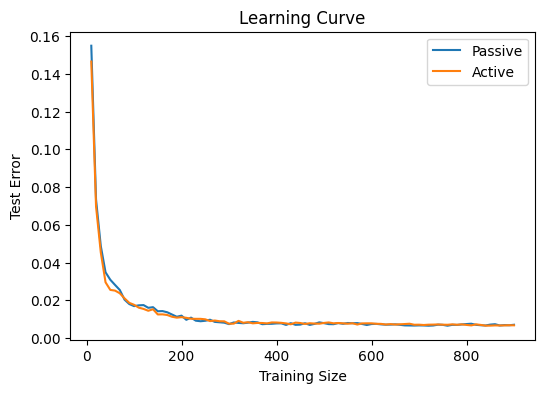

In [24]:
plot_learning_curve(active_learning_curve, passive_learning_curve)

### Observations:

* Active learning is a process where the model chooses the most informative data points to request for labels, leading to improved accuracy with fewer labeled examples. In contrast, passive learning utilizes all available labeled data without any selection strategy.

* Active learning can significantly enhance model performance by selecting the most informative examples for labeling, resulting in a more diverse and representative set of labeled data. This strategy also helps to mitigate overfitting and reduce the impact of noisy labels.